In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import norm

In [58]:
#read treatment1 data into dataframe
T1_no_diabetes =pd.read_excel('/Users/mehakrafiq/Library/CloudStorage/OneDrive-NationalUniversityofSciences&Technology/Desktop/upwork/MedicalStats/Treatment group 1.xlsx',sheet_name='No_diabetes')
T1_pre_diabetes = pd.read_excel('/Users/mehakrafiq/Library/CloudStorage/OneDrive-NationalUniversityofSciences&Technology/Desktop/upwork/MedicalStats/Treatment group 1.xlsx',sheet_name='Pre-diabetes')
T1_diabetes = pd.read_excel('/Users/mehakrafiq/Library/CloudStorage/OneDrive-NationalUniversityofSciences&Technology/Desktop/upwork/MedicalStats/Treatment group 1.xlsx',sheet_name='Diabetes')

In [61]:
#make one datafrafme of all three dataframes
T1_no_diabetes['no_diabetes'] = 1
T1_no_diabetes['pre_diabetes'] = 0
T1_no_diabetes['diabetes'] = 0

T1_pre_diabetes['no_diabetes'] = 0
T1_pre_diabetes['pre_diabetes'] = 1
T1_pre_diabetes['diabetes'] = 0

T1_diabetes['no_diabetes'] = 0
T1_diabetes['pre_diabetes'] = 0
T1_diabetes['diabetes'] = 1

treatment_1 = pd.concat([T1_no_diabetes, T1_pre_diabetes, T1_diabetes], ignore_index=True)
treatment_1.head()


,No diabetes,Gender (M),Gender (F),Case Number,Age,Length of Stay,BMI,Fall,U69.*,T81.*,...,N17.*,I21.*,R96.*,TOD,INTENSIV,no_diabetes,pre_diabetes,diabetes,Pre-Diabetes,Diabetes
0,1.0,0,1,1020062281,103,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1,0,0,NaN,NaN
1,1.0,1,0,1020085314,98,8,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,1,0,0,NaN,NaN
2,1.0,0,1,1020047252,98,4,22.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1,0,0,NaN,NaN
3,1.0,0,1,1019318116,97,12,21.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN
4,1.0,0,1,1019349783,97,7,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,1.0,1,0,0,NaN,NaN


In [62]:
# Drop the extra columns
treatment_1 = treatment_1.drop(columns=['No diabetes', 'Pre-Diabetes', 'Diabetes'])

# Fill NaN values with 0 in specified columns
columns_to_fill = ['Length of Stay','Fall', 'U69.*', 'T81.*', 'T84.*', 'N17.*', 'I21.*', 'R96.*', 'TOD', 'INTENSIV']
treatment_1[columns_to_fill] = treatment_1[columns_to_fill].fillna(0)

# Display the first few rows of the cleaned dataframe
treatment_1.head()


,Gender (M),Gender (F),Case Number,Age,Length of Stay,BMI,Fall,U69.*,T81.*,T84.*,N17.*,I21.*,R96.*,TOD,INTENSIV,no_diabetes,pre_diabetes,diabetes
0,0,1,1020062281,103,5,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
1,1,0,1020085314,98,8,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
2,0,1,1020047252,98,4,22.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
3,0,1,1019318116,97,12,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
4,0,1,1019349783,97,7,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0


In [12]:
treatment_1.to_excel('treatment1.xlsx', index=False

In [63]:
# Checking for NaN values in each column
nan_values = treatment_1.isna().sum()
nan_values

Gender (M)          0
Gender (F)          0
Case Number         0
Age                 0
Length of Stay      0
BMI               621
Fall                0
U69.*               0
T81.*               0
T84.*               0
N17.*               0
I21.*               0
R96.*               0
TOD                 0
INTENSIV            0
no_diabetes         0
pre_diabetes        0
diabetes            0
dtype: int64

In [64]:
#adding age bins to check for age distribution
# Define age groups
age_groups = ['18-40', '40-60', '60+']



# Define bins and labels for the age groups
bins = [18, 40, 60, treatment_1['Age'].max()]
labels = age_groups

# Create a new column 'age_group' based on the age groups defined
treatment_1['age_group'] = pd.cut(treatment_1['Age'], bins=bins, labels=labels, right=True, include_lowest=True)
treatment_1.head()


,Gender (M),Gender (F),Case Number,Age,Length of Stay,BMI,Fall,U69.*,T81.*,T84.*,N17.*,I21.*,R96.*,TOD,INTENSIV,no_diabetes,pre_diabetes,diabetes,age_group
0,0,1,1020062281,103,5,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,60+
1,1,0,1020085314,98,8,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,60+
2,0,1,1020047252,98,4,22.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,60+
3,0,1,1019318116,97,12,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,60+
4,0,1,1019349783,97,7,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,60+


In [65]:
# Finding the rows where the 'age_group' column has NaN values
nan_age_group_rows = treatment_1[treatment_1['age_group'].isna()]
nan_age_group_rows


,Gender (M),Gender (F),Case Number,Age,Length of Stay,BMI,Fall,U69.*,T81.*,T84.*,N17.*,I21.*,R96.*,TOD,INTENSIV,no_diabetes,pre_diabetes,diabetes,age_group


In [66]:
# Calculate descriptive statistics for each group
desc_stats = treatment_1.groupby(['no_diabetes', 'pre_diabetes', 'diabetes']).agg(
    mean_age=('Age', 'mean'),
    median_age=('Age', 'median'),
    std_age=('Age', 'std'),
    mean_length_of_stay=('Length of Stay', 'mean'),
    median_length_of_stay=('Length of Stay', 'median'),
    std_length_of_stay=('Length of Stay', 'std'),
    mean_BMI=('BMI', 'mean'),
    median_BMI=('BMI', 'median'),
    std_BMI=('BMI', 'std'),
)

# Display the descriptive statistics
desc_stats.reset_index()


,no_diabetes,pre_diabetes,diabetes,mean_age,median_age,std_age,mean_length_of_stay,median_length_of_stay,std_length_of_stay,mean_BMI,median_BMI,std_BMI
0,0,0,1,70.229032,71.0,12.745040,12.196774,8.0,11.954471,30.380513,28.6,8.405437
1,0,1,0,69.514493,70.0,12.382726,11.731884,8.0,9.313313,29.664151,27.7,9.793819
2,1,0,0,56.722551,58.0,20.040927,10.073636,7.0,9.533382,26.728909,25.4,7.009980


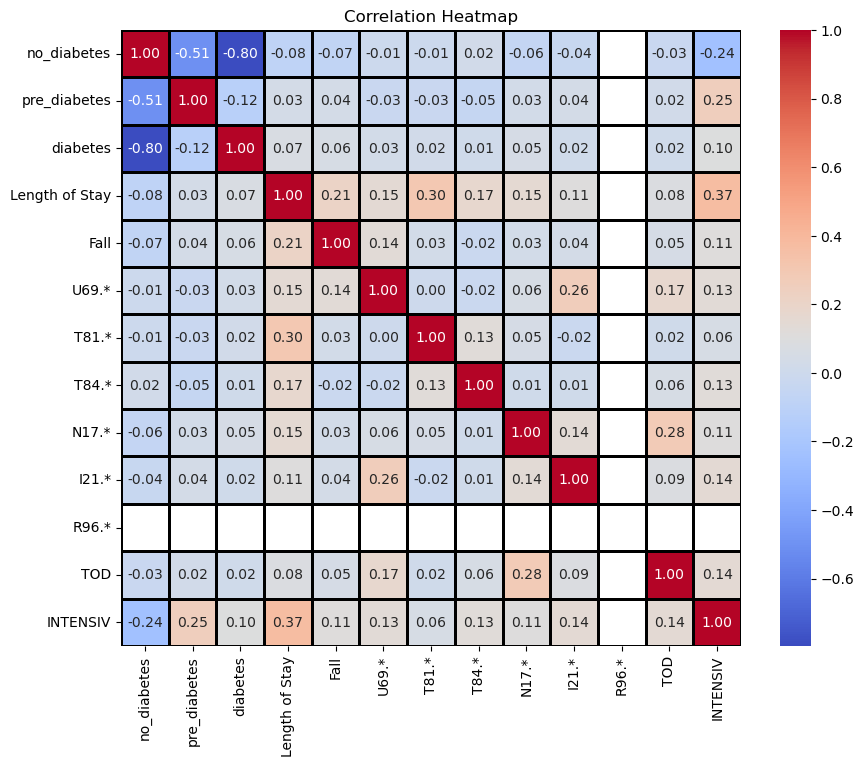

In [67]:
# Heatmap of conditions with complications
#Select the columns to be used for the heatmap
cols = ['no_diabetes', 'pre_diabetes', 'diabetes', 'Length of Stay', 'Fall', 'U69.*', 'T81.*', 'T84.*', 'N17.*', 'I21.*', 'R96.*', 'TOD', 'INTENSIV']
correlation_matrix = treatment_1[cols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, linecolor='black')

# Set title and show plot
plt.title('Correlation Heatmap')
plt.show()

In [68]:
# Perform one-way ANOVA for any variable of interest
def one_way_anova(df, variable_of_interest):
    f_statistic, p_value = f_oneway(
        df[variable_of_interest][df['no_diabetes'] == 1],
        df[variable_of_interest][df['pre_diabetes'] == 1],
        df[variable_of_interest][df['diabetes'] == 1]
    )
    return f_statistic, p_value

In [69]:
length_of_stay_f_statistic, length_of_stay_p_value = one_way_anova(treatment_1, 'Length of Stay')
length_of_stay_f_statistic, length_of_stay_p_value

(6.971915634681189, 0.0009612194624364765)

In [70]:
# Perform t-test for any variable of interest
def t_test(df, variable_of_interest, condition_1, condition_2):
    t_statistic, p_value = ttest_ind(
        df[variable_of_interest][df[condition_1] == 1],
        df[variable_of_interest][df[condition_2] == 1]
    )
    return t_statistic, p_value

In [71]:
length_of_stay_t_statistic_pre_diabates, length_of_stay_p_value_pre_diabates = t_test(treatment_1, 'Length of Stay', 'no_diabetes', 'pre_diabetes')
length_of_stay_t_statistic_pre_diabates, length_of_stay_p_value_pre_diabates

(-1.9602181461651302, 0.050137657552201634)

In [72]:
length_of_stay_t_statistic_diabetes, length_of_stay_p_value_diabetes = t_test(treatment_1, 'Length of Stay', 'no_diabetes', 'diabetes')
length_of_stay_t_statistic_diabetes, length_of_stay_p_value_diabetes

(-3.412616244105461, 0.000657444206221038)

In [73]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#Perform Tukey HSD post-hoc test for any variable of interest
def tukey_hsd(df, variable_of_interest):
    # Create a new column 'group' to indicate the group of each row (no_diabetes, pre_diabetes, diabetes)
    df['group'] = df.apply(lambda row: 'no_diabetes' if row['no_diabetes'] == 1 else ('pre_diabetes' if row['pre_diabetes'] == 1 else 'diabetes'), axis=1)
    tukey_results = pairwise_tukeyhsd(df[variable_of_interest], df['group'])
    return tukey_results


In [74]:
# Applying the function and getting the summary
length_of_stay_tukey = tukey_hsd(treatment_1, 'Length of Stay')
print(length_of_stay_tukey.summary())


      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2    meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
   diabetes  no_diabetes  -2.1231 0.0018 -3.5758 -0.6705   True
   diabetes pre_diabetes  -0.4649 0.8912 -2.8503  1.9206  False
no_diabetes pre_diabetes   1.6582 0.1457 -0.4141  3.7306  False
---------------------------------------------------------------


Post-Hoc Tests Results (Tukey HSD)
No Diabetes (100) vs Pre-Diabetes (010): The mean difference in "Length of Stay" is not significantly different (p=0.8821).
No Diabetes (100) vs Diabetes (001): The mean "Length of Stay" is significantly shorter in the Diabetes group compared to the No Diabetes group (p=0.0018).
Pre-Diabetes (010) vs Diabetes (001): The mean difference in "Length of Stay" is not significantly different (p=0.1458).

In [82]:
# Visualize the tukey results for any variable of interest
def visualize_tukey_results(tukey_results, variable_of_interest):
    plt.figure(figsize=(10, 8)) # Set the size of the figure
    tukey_results.plot_simultaneous() # Plot group confidence intervals
    #calculating the mean
    mean = treatment_1[variable_of_interest].mean() # Calculate the mean of the data
    plt.vlines(x=mean, ymin=-0.5, ymax=2.5, color="red") # Add a vertical line at the mean of the data

    # Add a title and axis labels
    xlabel = "Mean " + variable_of_interest # Define x-axis label
    ylabel = "Group" # Define y-axis label
    plt.xlabel(xlabel) # Set x-axis label
    plt.ylabel(ylabel) # Set y-axis label

    plt.show()

<Figure size 1000x800 with 0 Axes>

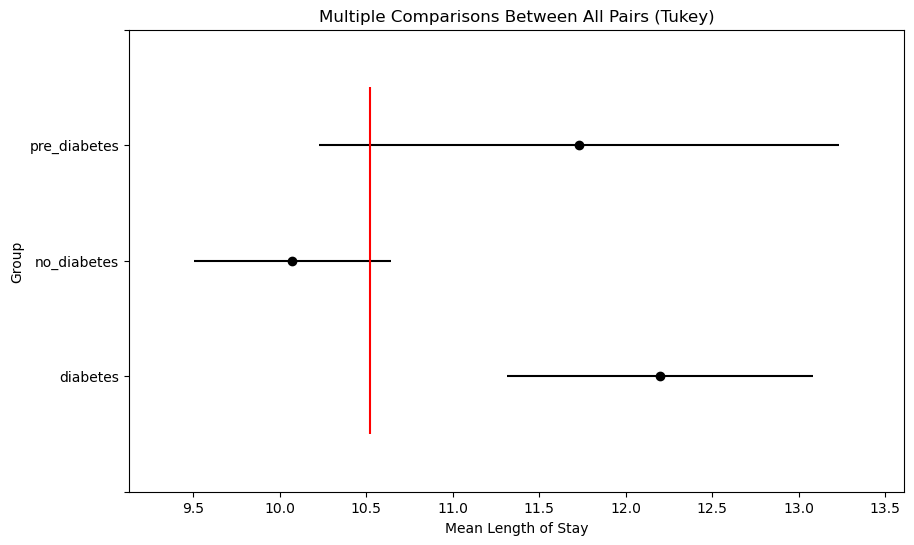

In [83]:
# Testing the function for length of stay
visualize_tukey_results(length_of_stay_tukey, 'Length of Stay')

In [93]:
from scipy.stats import chi2_contingency
# Perform chi-square test for any variable of interest 
def chi_square_test(df, variable_of_interest):
    # Create a contingency table for each condition 
    contingency_table_no_diabetes = pd.crosstab(df[variable_of_interest], df['no_diabetes'])
    contingency_table_pre_diabetes = pd.crosstab(df[variable_of_interest], df['pre_diabetes'])
    contingency_table_diabetes = pd.crosstab(df[variable_of_interest], df['diabetes'])

    # Perform the chi-square test for each condition
    chi2_no_diabetes, p_value_no_diabetes, dof_no_diabetes, _ = chi2_contingency(contingency_table_no_diabetes)
    chi2_pre_diabetes, p_value_pre_diabetes, dof_pre_diabetes, _ = chi2_contingency(contingency_table_pre_diabetes)
    chi2_diabetes, p_value_diabetes, dof_diabetes, _ = chi2_contingency(contingency_table_diabetes)

    #compile the results into a dataframe
    chi_square_results = pd.DataFrame({
        'condition': ['no_diabetes', 'pre_diabetes', 'diabetes'],
        'chi2': [chi2_no_diabetes, chi2_pre_diabetes, chi2_diabetes],
        'p_value': [p_value_no_diabetes, p_value_pre_diabetes, p_value_diabetes],
        'dof': [dof_no_diabetes, dof_pre_diabetes, dof_diabetes]
    })  
    return chi_square_results


In [95]:
#test function for any variable of interest
chi_square_results_length_of_stay = chi_square_test(treatment_1, 'Length of Stay')
chi_square_results_length_of_stay

,condition,chi2,p_value,dof
0,no_diabetes,88.129727,0.016262,62
1,pre_diabetes,72.794754,0.164202,62
2,diabetes,76.744911,0.098440,62


In [120]:
#visualize the results

def visualize_chi_square_results(df, variable, chi2_results):
    sns.set(style='whitegrid')
    
    # Create a new column representing the conditions
    condition_labels = ['No Diabetes']*df['no_diabetes'].sum() + \
                       ['Pre-Diabetes']*df['pre_diabetes'].sum() + \
                       ['Diabetes']*df['diabetes'].sum()
    
    # Adding the new column to the dataframe
    df['condition'] = condition_labels
    
    # Creating a bar plot to visualize the proportion of individuals with the complication in each group
    plt.figure(figsize=(10, 6))
    sns.barplot(x='condition', y=variable, data=df, errorbar=None)
    
    # Adding labels and title to the plot
    plt.ylabel(f'Proportion of Individuals with "{variable}" Complication')
    plt.xlabel('Condition')
    plt.title(f'Proportion of Individuals Experiencing "{variable}" Complication by Condition')
    
    # Adding p-value asterisks
    # The y-coordinate for the p-value annotations is based on the maximum value in the variable column
    y_max = df.groupby('condition')[variable].mean().max() - 0.01
    
    # Display the plot
    plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/DataAnalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/DataAnalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/DataAnalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


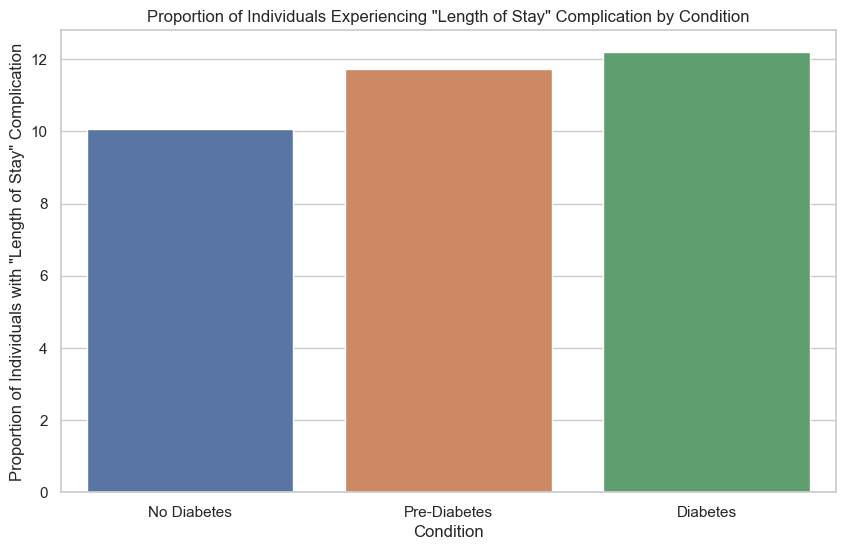

In [119]:
#test function for length of stay
visualize_chi_square_results(treatment_1, 'Length of Stay', chi_square_results_length_of_stay)


In [106]:
# Perform relative risk analysis for any variable of interest
def relative_risk_analysis(df, variable_of_interest):
    # Create a contingency table for each condition 
    contingency_table_no_diabetes = pd.crosstab(df[variable_of_interest], df['no_diabetes'])
    contingency_table_pre_diabetes = pd.crosstab(df[variable_of_interest], df['pre_diabetes'])
    contingency_table_diabetes = pd.crosstab(df[variable_of_interest], df['diabetes'])

    # Calculate the relative risk for each condition
    relative_risk_no_diabetes = contingency_table_no_diabetes.iloc[1, 1] / contingency_table_no_diabetes.iloc[0, 1]
    relative_risk_pre_diabetes = contingency_table_pre_diabetes.iloc[1, 1] / contingency_table_pre_diabetes.iloc[0, 1]
    relative_risk_diabetes = contingency_table_diabetes.iloc[1, 1] / contingency_table_diabetes.iloc[0, 1]

    # Calculate the 95% confidence interval for each condition
    ci_no_diabetes = np.exp(np.log(relative_risk_no_diabetes) + norm.ppf(0.025) * np.sqrt(1 / contingency_table_no_diabetes.iloc[1, 1] + 1 / contingency_table_no_diabetes.iloc[0, 1]))
    ci_pre_diabetes = np.exp(np.log(relative_risk_pre_diabetes) + norm.ppf(0.025) * np.sqrt(1 / contingency_table_pre_diabetes.iloc[1, 1] + 1 / contingency_table_pre_diabetes.iloc[0, 1]))
    ci_diabetes = np.exp(np.log(relative_risk_diabetes) + norm.ppf(0.025) * np.sqrt(1 / contingency_table_diabetes.iloc[1, 1] + 1 / contingency_table_diabetes.iloc[0, 1]))


    # Calculate the p-value for each condition
    p_value_no_diabetes = norm.cdf(-np.abs(np.log(relative_risk_no_diabetes) / np.sqrt(1 / contingency_table_no_diabetes.iloc[1, 1] + 1 / contingency_table_no_diabetes.iloc[0, 1])))
    p_value_pre_diabetes = norm.cdf(-np.abs(np.log(relative_risk_pre_diabetes) / np.sqrt(1 / contingency_table_pre_diabetes.iloc[1, 1] + 1 / contingency_table_pre_diabetes.iloc[0, 1])))
    p_value_diabetes = norm.cdf(-np.abs(np.log(relative_risk_diabetes) / np.sqrt(1 / contingency_table_diabetes.iloc[1, 1] + 1 / contingency_table_diabetes.iloc[0, 1])))

    # Compile the results into a dataframe
    relative_risk_results = pd.DataFrame({
        'condition': ['no_diabetes', 'pre_diabetes', 'diabetes'],
        'relative_risk': [relative_risk_no_diabetes, relative_risk_pre_diabetes, relative_risk_diabetes],
        'ci': [ci_no_diabetes, ci_pre_diabetes, ci_diabetes],
        'p_value': [p_value_no_diabetes, p_value_pre_diabetes, p_value_diabetes]
    })
    return relative_risk_results


In [107]:
#test function for length of stay
relative_risk_results_length_of_stay = relative_risk_analysis(treatment_1, 'Length of Stay')
relative_risk_results_length_of_stay

,condition,relative_risk,ci,p_value
0,no_diabetes,1.013636,0.841389,0.443329
1,pre_diabetes,1.222222,0.506481,0.327631
2,diabetes,1.576923,0.964744,0.034624


In [114]:
# Visualize the relative risk results for any variable of interest using a forest plot
def visualize_relative_risk_results(relative_risk_results, variable_of_interest):
    plt.figure(figsize=(10, 8)) # Set the size of the figure
    plt.scatter(relative_risk_results['relative_risk'], relative_risk_results['condition']) # Plot the relative risks
    plt.errorbar(relative_risk_results['relative_risk'], relative_risk_results['condition'], xerr=relative_risk_results['ci'], linestyle="None") # Plot the confidence intervals
    plt.axvline(x=1, color='r', linestyle='--') # Add a vertical line at relative risk = 1
    plt.title('Relative risk for ' + variable_of_interest) # Add a title
    plt.ylabel('condition') # Add y-label
    plt.xlabel('relative risk') # Add x-label
    plt.show()

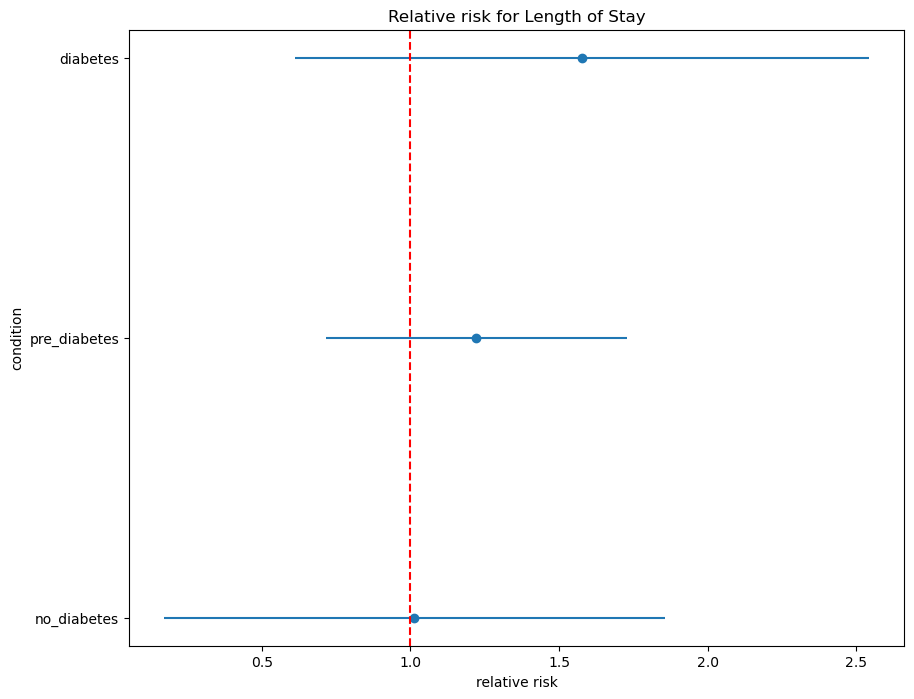

In [115]:
#test function for length of stay
visualize_relative_risk_results(relative_risk_results_length_of_stay, 'Length of Stay')


In [135]:
from scipy.stats import fisher_exact
# Perform odds ratio analysis for any variable of interest
def odds_ratio_analysis(df, variable_of_interest):
    
    #find suitable value to divide the variable of interest into two groups
    median = df[variable_of_interest].median()
    
    # Create a new column 'group' to indicate the group of each row (no_diabetes, pre_diabetes, diabetes)
    df['group'] = df.apply(lambda row: 'low' if row[variable_of_interest] <= median else 'high', axis=1)

    # Create a contingency table 2 x2 for each condition
    contingency_table_no_diabetes = pd.crosstab(df['group'], df['no_diabetes'])
    contingency_table_pre_diabetes = pd.crosstab(df['group'], df['pre_diabetes'])
    contingency_table_diabetes = pd.crosstab(df['group'], df['diabetes'])

    # Calculate the odds ratio for each condition
    odds_ratio_no_diabetes, p_value_no_diabetes = fisher_exact(contingency_table_no_diabetes)
    odds_ratio_pre_diabetes, p_value_pre_diabetes = fisher_exact(contingency_table_pre_diabetes)
    odds_ratio_diabetes, p_value_diabetes = fisher_exact(contingency_table_diabetes)

    #calculate the 95% confidence interval for each condition
    ci_no_diabetes = np.exp(np.log(odds_ratio_no_diabetes) + norm.ppf(0.025) * np.sqrt(1 / contingency_table_no_diabetes.iloc[1, 1] + 1 / contingency_table_no_diabetes.iloc[0, 1]))
    ci_pre_diabetes = np.exp(np.log(odds_ratio_pre_diabetes) + norm.ppf(0.025) * np.sqrt(1 / contingency_table_pre_diabetes.iloc[1, 1] + 1 / contingency_table_pre_diabetes.iloc[0, 1]))
    ci_diabetes = np.exp(np.log(odds_ratio_diabetes) + norm.ppf(0.025) * np.sqrt(1 / contingency_table_diabetes.iloc[1, 1] + 1 / contingency_table_diabetes.iloc[0, 1]))


    # Compile the results into a dataframe
    odds_ratio_results = pd.DataFrame({
        'condition': ['no_diabetes', 'pre_diabetes', 'diabetes'],
        'odds_ratio': [odds_ratio_no_diabetes, odds_ratio_pre_diabetes, odds_ratio_diabetes],
        'ci': [ci_no_diabetes, ci_pre_diabetes, ci_diabetes],
        'p_value': [p_value_no_diabetes, p_value_pre_diabetes, p_value_diabetes]
    })
    
    return odds_ratio_results
   


In [137]:
#test function for length of stay
odds_ratio_results_length_of_stay = odds_ratio_analysis(treatment_1, 'Length of Stay')
odds_ratio_results_length_of_stay


,condition,odds_ratio,ci,p_value
0,no_diabetes,1.562437,1.412080,0.000041
1,pre_diabetes,0.559216,0.397725,0.001377
2,diabetes,0.735729,0.588608,0.015501


In [139]:
# Visualize the odds ratio results for any variable of interest using a forest plot
def visualize_odds_ratio_results(odds_ratio_results, variable_of_interest):
    plt.figure(figsize=(10, 8)) # Set the size of the figure
    plt.scatter(odds_ratio_results['odds_ratio'], odds_ratio_results['condition']) # Plot the odds ratios
    plt.errorbar(odds_ratio_results['odds_ratio'], odds_ratio_results['condition'], xerr=odds_ratio_results['ci'], linestyle="None") # Plot the confidence intervals
    plt.axvline(x=1, color='r', linestyle='--') # Add a vertical line at odds ratio = 1
    plt.title('Odds ratio for ' + variable_of_interest) # Add a title
    plt.ylabel('condition') # Add y-label
    plt.xlabel('odds ratio') # Add x-label
    plt.show()
    

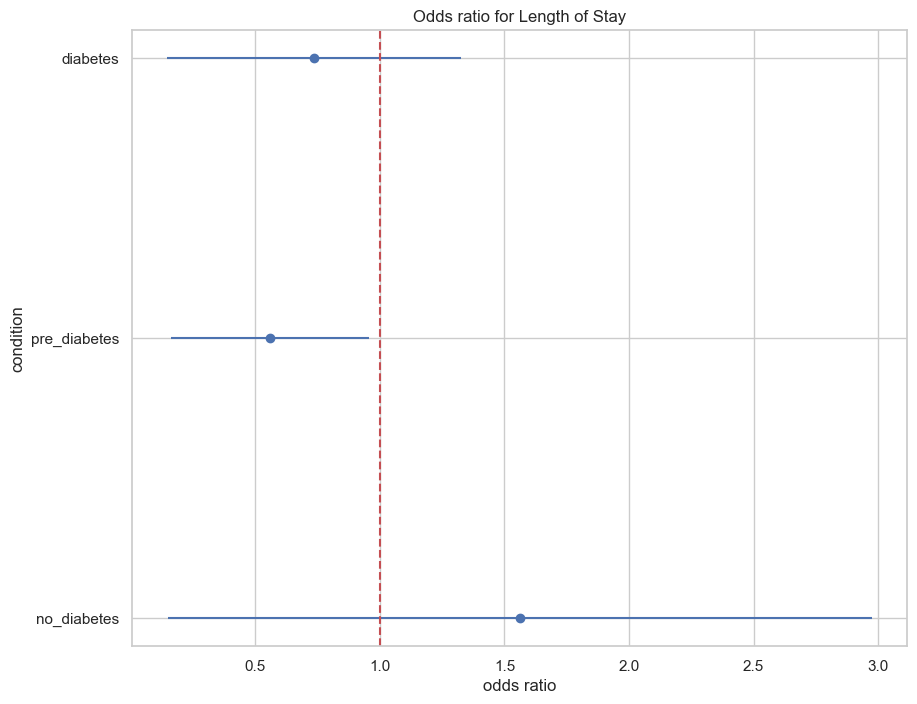

In [140]:
#test function for length of stay
visualize_odds_ratio_results(odds_ratio_results_length_of_stay, 'Length of Stay')


In [173]:
from scipy.stats import fisher_exact, norm
import numpy as np
import pandas as pd

def relative_risk_by_age(df, variable_of_interest):
    # Create a new column indicating whether the variable of interest is above or below the median
    median = df[variable_of_interest].median()
    df['group'] = df.apply(lambda row: 'low' if row[variable_of_interest] <= median else 'high', axis=1)
    
    # Create a new column representing the conditions
    condition_labels = ['No Diabetes']*df['no_diabetes'].sum() + \
                        ['Pre-Diabetes']*df['pre_diabetes'].sum() + \
                        ['Diabetes']*df['diabetes'].sum()
    df['condition'] = condition_labels

    # Get unique age groups and conditions
    age_groups = df['age_group'].unique()
    conditions = df['condition'].unique()

    results = []

    # Recreate contingency tables for each age group, calculate relative risk and p-value
    for age_group in age_groups:
        for condition in conditions:
            sub_df = df[df['age_group'] == age_group]
            contingency_table = pd.crosstab(sub_df['group'], sub_df['condition'] == condition)
            
            if contingency_table.shape == (2, 2):
                # Calculate the relative risk for each condition
                relative_risk, p_value = fisher_exact(contingency_table)

                # Calculate the 95% confidence interval for each condition
                confidence_interval = np.exp(np.log(relative_risk) + norm.ppf(0.025) * np.sqrt(1 / contingency_table.iloc[1, 1] + 1 / contingency_table.iloc[0, 1]))

                results.append({
                    'age_group': age_group,
                    'condition': condition,
                    'relative_risk': relative_risk,
                    'p_value': p_value,
                    'confidence_interval': confidence_interval
                })

    
    # Compile the results into a dataframe
    relative_risk_by_age_results = pd.DataFrame(results)
    #sort the dataframe by age group smallest first
    relative_risk_by_age_results = relative_risk_by_age_results.sort_values(by='age_group')
    
    
    return relative_risk_by_age_results


In [174]:
#test function for length of stay
relative_risk_by_age_results_length_of_stay = relative_risk_by_age(treatment_1, 'Length of Stay')
relative_risk_by_age_results_length_of_stay

,age_group,condition,relative_risk,p_value,confidence_interval
6,18-40,No Diabetes,0.893462,1.000000,0.717395
7,18-40,Pre-Diabetes,0.956175,1.000000,0.086703
8,18-40,Diabetes,1.199597,1.000000,0.232739
3,40-60,No Diabetes,1.744865,0.023910,1.453073
4,40-60,Pre-Diabetes,0.275778,0.002005,0.122781
5,40-60,Diabetes,0.893918,0.775392,0.526506
0,60+,No Diabetes,1.184561,0.212791,1.020048
1,60+,Pre-Diabetes,0.831081,0.409930,0.564656
2,60+,Diabetes,0.889526,0.466115,0.692559


In [187]:
# Visualize the relative risk by age results for any variable of interest using a forest plot
import matplotlib.pyplot as plt

def visualize_relative_risk_by_age_results(relative_risk_by_age_results, variable_of_interest):
    # Initialize the figure
    plt.figure(figsize=(10, 6))
    
    # Loop through each condition and age group to plot the relative risk and confidence interval
    for i, row in relative_risk_by_age_results.iterrows():
        plt.plot([row['relative_risk'] - row['confidence_interval'], row['relative_risk'] + row['confidence_interval']], [i, i], 'k-', lw=1)
        plt.plot(row['relative_risk'], i, 'ko')
    
    # Adding labels, title, and grid
    labels = relative_risk_by_age_results.apply(lambda row: f"{row['age_group']} {row['condition']}", axis=1)
    plt.yticks(range(len(relative_risk_by_age_results)), labels)
    #plt.xscale('log')  # Set x-axis to log scale for better visualization of data spanning several orders of magnitude
    plt.xlabel('Relative Risk')
    plt.title(f'Relative Risk of High {variable_of_interest} with 95% Confidence Intervals')
    plt.axvline(x=1, color='red', linestyle='--')  # Line of no effect
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Display the plot
    plt.show()


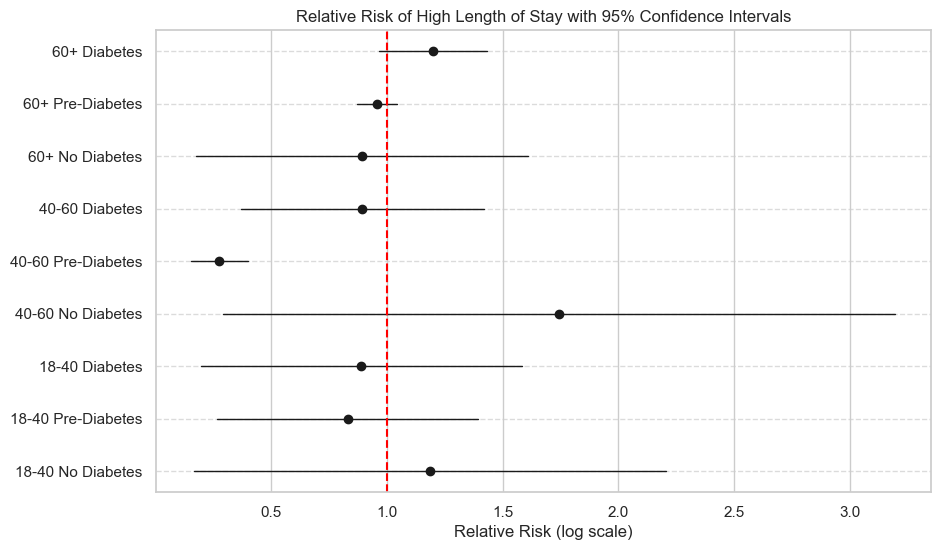

In [186]:
#test function for length of stay
visualize_relative_risk_by_age_results(relative_risk_by_age_results_length_of_stay, 'Length of Stay')

In [ ]:
#Controlling for age
# Create a new column indicating whether the length of stay is above the median
median_length_of_stay = treatment_1['Length of Stay'].median()
treatment_1['Length_of_Stay_High'] = (treatment_1['Length of Stay'] > median_length_of_stay).astype(int)

# Recreate contingency tables for each age group, calculate relative risks, and calculate p-values
rr_results_statsmodels_los = []

for age_group in age_groups:
    # Create a contingency table for the age group
    contingency_table = pd.crosstab(treatment_1[treatment_1['age_group'] == age_group]['Length_of_Stay_High'], 
                                    treatment_1[treatment_1['age_group'] == age_group]['condition'])
    
    # Ensure the contingency table has rows for both outcomes (0 and 1) for each condition
    for condition in ['no_diabetes', 'pre_diabetes', 'diabetes']:
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 0).any()):
            contingency_table.loc[0, condition] = 0
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 1).any()):
            contingency_table.loc[1, condition] = 0
    
    # Sort the index to have a proper contingency table structure
    contingency_table.sort_index(inplace=True)
    
    # Calculate relative risk and confidence intervals with statsmodels
    rr_df = calculate_relative_risk_with_statsmodels(contingency_table.values)
    rr_df['Age Group'] = age_group
    
    # Calculate p-values and add to the dataframe
    rr_df['p-value'] = rr_df.apply(lambda row: calculate_p_value(contingency_table.iloc[:, :2].values + 0.5) if row['Condition'] == 'Pre-Diabetes' 
                                   else calculate_p_value(contingency_table.iloc[:, [0, 2]].values + 0.5), axis=1)
    
    rr_results_statsmodels_los.append(rr_df)

# Combine the results from all age groups into a single dataframe
rr_results_statsmodels_los_df = pd.concat(rr_results_statsmodels_los, axis=0).reset_index(drop=True)
rr_results_statsmodels_los_df


,Condition,Relative Risk,95% CI Lower,95% CI Upper,Age Group,p-value
0,Pre-Diabetes,0.911504,0.169658,4.897135,20-40,1.000000
1,Diabetes,1.000000,0.375318,2.664408,20-40,1.000000
2,Pre-Diabetes,0.802415,0.471583,1.365335,40-60,0.496672
3,Diabetes,1.357323,0.977183,1.885344,40-60,0.135077
4,Pre-Diabetes,0.906166,0.733103,1.120084,60+,0.404226
5,Diabetes,1.047053,0.916018,1.196832,60+,0.589083


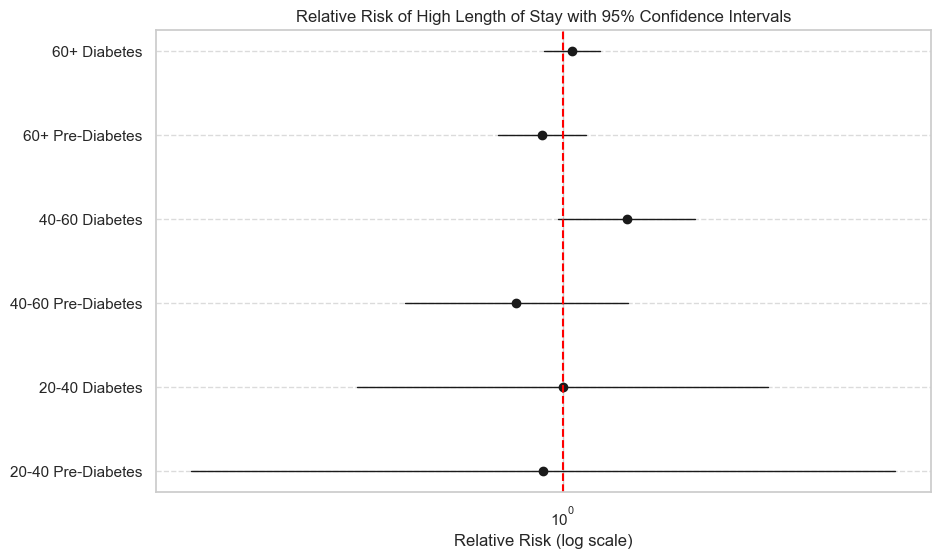

In [ ]:
# Plotting the forest plot for length of stay
plt.figure(figsize=(10, 6))

# Loop through each condition and age group to plot the relative risk and confidence interval
for i, row in rr_results_statsmodels_los_df.iterrows():
    plt.plot([row['95% CI Lower'], row['95% CI Upper']], [i, i], 'k-', lw=1)
    plt.plot(row['Relative Risk'], i, 'ko')
    
# Adding labels, title, and grid
plt.yticks(range(len(rr_results_statsmodels_los_df)), 
           ['20-40 Pre-Diabetes', '20-40 Diabetes', '40-60 Pre-Diabetes', '40-60 Diabetes', '60+ Pre-Diabetes', '60+ Diabetes'])
plt.xscale('log')  # Set x-axis to log scale for better visualization of data spanning several orders of magnitude
plt.xlabel('Relative Risk (log scale)')
plt.title('Relative Risk of High Length of Stay with 95% Confidence Intervals')
plt.axvline(x=1, color='red', linestyle='--')  # Line of no effect
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


From the plot, it appears that:

For the age group 20-40, both Pre-Diabetes and Diabetes groups do not have a statistically significant difference in the risk of having a high length of stay compared to the No Diabetes group.
For the age group 40-60, the Diabetes group seems to have a higher risk, although not statistically significant.
For the age group 60+, there is no statistically significant difference in the risk of having a high length of stay for both the Pre-Diabetes and Diabetes groups compared to the No Diabetes group.
This is supported by the p-values in the table above, which are all above the 0.05 threshold for statistical significance

In [ ]:
#relative risk of each event to each condition lets start by comparing fall
#correlation between fall and no_diabetes, pre_diabetes, diabetes
correlation_with_fall = treatment_1[['Fall', 'no_diabetes', 'pre_diabetes','diabetes']].corr()
correlation_with_fall['Fall']

Fall            1.000000
no_diabetes    -0.069890
pre_diabetes    0.036037
diabetes        0.055188
Name: Fall, dtype: float64

In [ ]:
#chi-square test for fall
from scipy.stats import chi2_contingency

# Create a contingency table
contigency_no_diabetes = pd.crosstab(treatment_1['Fall'], treatment_1['no_diabetes'])
contigency_pre_diabetes = pd.crosstab(treatment_1['Fall'], treatment_1['pre_diabetes'])
contigency_diabetes = pd.crosstab(treatment_1['Fall'], treatment_1['diabetes'])

#perfrom chi-square test
chi2_no_diabetes, p_value_no_diabetes, dof_no_diabetes, expected_no_diabetes = chi2_contingency(contigency_no_diabetes)
chi2_pre_diabetes, p_value_pre_diabetes, dof_pre_diabetes, expected_pre_diabetes = chi2_contingency(contigency_pre_diabetes)
chi2_diabetes, p_value_diabetes, dof_diabetes, expected_diabetes = chi2_contingency(contigency_diabetes)

chi2_results = pd.DataFrame({
    'Condition': ['No Diabetes', 'Pre-Diabetes', 'Diabetes'],
    'Chi-square value': [chi2_no_diabetes, chi2_pre_diabetes, chi2_diabetes],
    'p-value': [p_value_no_diabetes, p_value_pre_diabetes, p_value_diabetes],
})

chi2_results

,Condition,Chi-square value,p-value
0,No Diabetes,8.782065,0.003042
1,Pre-Diabetes,1.884536,0.169819
2,Diabetes,5.245366,0.022005


There is Statistical significance between fall and no_diabetes (p-value <0.05)
There is no statistical signifacne between fall & pre_diabetes
there is statistical significance between fall & Diabetes (p-value <0.05>)

C:\Users\Mehak Rafiq\AppData\Local\Temp\ipykernel_20036\1921449425.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='condition', y='Fall', data=treatment_1, ci=None)


<Figure size 800x600 with 0 Axes>

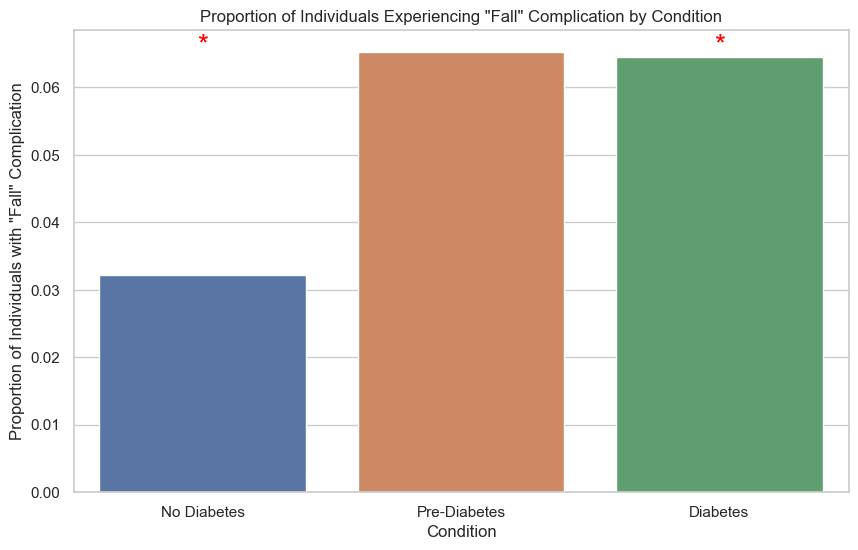

In [ ]:
#visualize the results
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

# Create a new column representing the conditions
condition_labels = ['No Diabetes']*treatment_1['no_diabetes'].sum() + \
                   ['Pre-Diabetes']*treatment_1['pre_diabetes'].sum() + \
                   ['Diabetes']*treatment_1['diabetes'].sum()

# Adding the new column to the dataframe
treatment_1['condition'] = condition_labels

# Creating a bar plot to visualize the proportion of individuals with the "Fall" complication in each group
plt.figure(figsize=(10, 6))
sns.barplot(x='condition', y='Fall', data=treatment_1, ci=None)

# Adding labels and title to the plot
plt.ylabel('Proportion of Individuals with "Fall" Complication')
plt.xlabel('Condition')
plt.title('Proportion of Individuals Experiencing "Fall" Complication by Condition')

# Adding p-value asterisks
# The y-coordinate for the p-value annotations is based on the maximum value in the 'Fall' column
y_max = treatment_1.groupby('condition')['Fall'].mean().max() - 0.001
plt.text(0, y_max, '*', ha='center', va='bottom', fontsize=20, color='red')
plt.text(2, y_max, '*', ha='center', va='bottom', fontsize=20, color='red')

# Display the plot
plt.show()


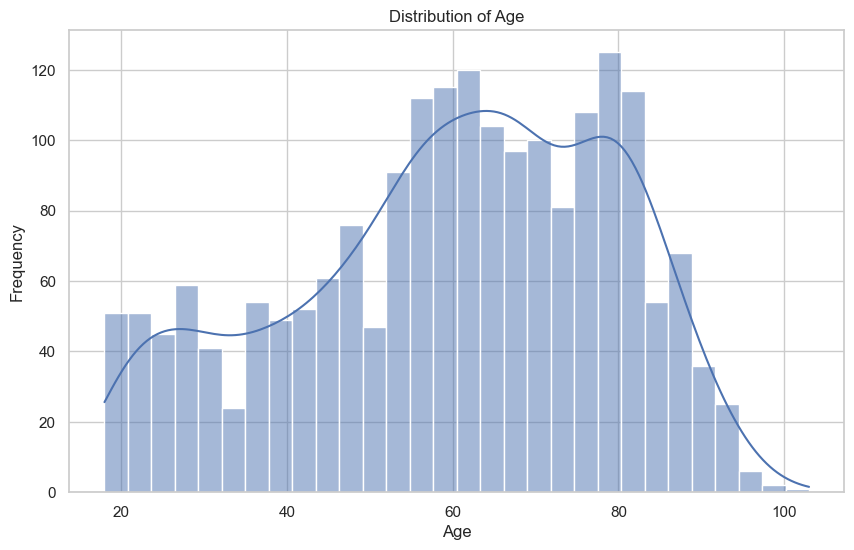

count    1969.000000
mean       59.745556
std        19.428176
min        18.000000
25%        47.000000
50%        62.000000
75%        76.000000
max       103.000000
Name: Age, dtype: float64

In [ ]:

# Setting the style of seaborn
sns.set(style="whitegrid")

# Creating a histogram to visualize the distribution of ages in the dataset
plt.figure(figsize=(10, 6))
sns.histplot(treatment_1['Age'], bins=30, kde=True)

# Adding labels and title to the plot
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

# Display the plot
plt.show()

# Displaying summary statistics for the 'Age' column
age_summary = treatment_1['Age'].describe()
age_summary


In [ ]:
# Define age bins
age_bins = [20, 40, 60, treatment_1['Age'].max()+1]

# Create a new column representing age groups
treatment_1['age_group'] = pd.cut(treatment_1['Age'], bins=age_bins, right=False, labels=['20-40', '40-60', '60+'])

# Function to calculate confidence interval
def calculate_confidence_interval(data, confidence_level=0.95):
    mean_val = data.mean()
    std_err = data.sem()
    ci = std_err * norm.ppf((1 + confidence_level) / 2)
    return mean_val, ci

# Calculate the mean and confidence interval for each condition within each age group
forest_plot_data = treatment_1.groupby(['age_group', 'condition'])['Fall'].apply(calculate_confidence_interval).reset_index()
forest_plot_data[['mean', 'CI']] = pd.DataFrame(forest_plot_data['Fall'].to_list(), index=forest_plot_data.index)
forest_plot_data.drop(columns='Fall', inplace=True)

forest_plot_data


,age_group,condition,mean,CI
0,20-40,Diabetes,0.000000,0.000000
1,20-40,No Diabetes,0.012384,0.012079
2,20-40,Pre-Diabetes,0.000000,0.000000
3,40-60,Diabetes,0.020408,0.039999
4,40-60,No Diabetes,0.017699,0.012169
5,40-60,Pre-Diabetes,0.037037,0.072591
6,60+,Diabetes,0.074510,0.032294
7,60+,No Diabetes,0.051532,0.016182
8,60+,Pre-Diabetes,0.074074,0.049622


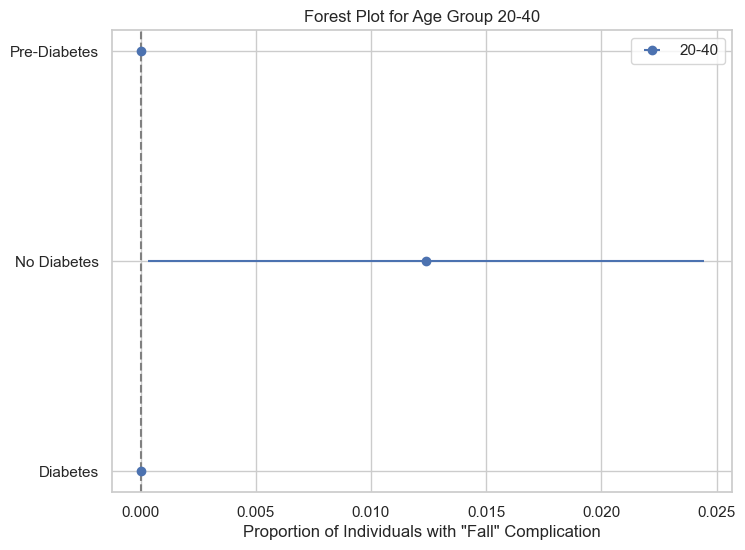

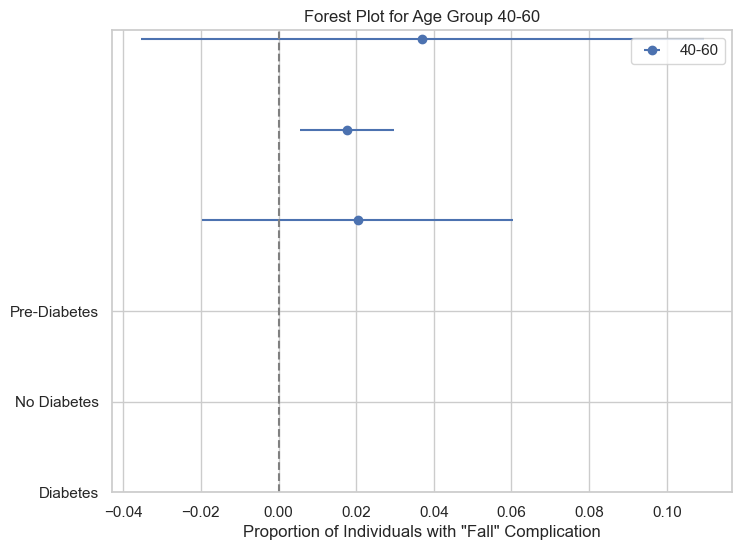

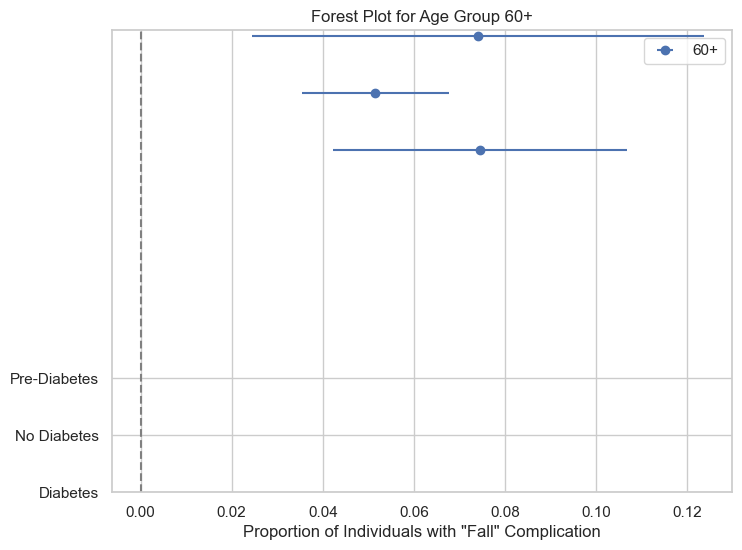

In [ ]:
# Importing necessary library for creating forest plot
import matplotlib.pyplot as plt

# Function to create forest plot
def create_forest_plot(data, group_col, mean_col, ci_col, title):
    plt.figure(figsize=(8, 6))
    
    # Get unique groups
    groups = data[group_col].unique()
    
    # Plotting the error bars
    for i, group in enumerate(groups):
        group_data = data[data[group_col] == group]
        plt.errorbar(x=group_data[mean_col], y=group_data.index, xerr=group_data[ci_col], fmt='o', label=group)
    
    # Adding labels and title
    plt.xlabel('Proportion of Individuals with "Fall" Complication')
    plt.yticks(ticks=range(len(data)), labels=data[condition_col])
    plt.title(title)
    plt.axvline(0, color='gray', linestyle='--')  # Adding a vertical line at x=0 for reference
    plt.legend()
    
    # Display the plot
    plt.show()

# Column names
group_col = 'age_group'
condition_col = 'condition'
mean_col = 'mean'
ci_col = 'CI'

# Creating forest plot for each age group
for age_group in forest_plot_data['age_group'].unique():
    create_forest_plot(forest_plot_data[forest_plot_data['age_group'] == age_group], group_col, mean_col, ci_col, f'Forest Plot for Age Group {age_group}')


Observations:
In the 20-40 years age group, the "No Diabetes" group has a small proportion of individuals with the "Fall" complication, while no individuals in the "Diabetes" and "Pre-Diabetes" groups experienced this complication.
In the 40-60 years age group, all three conditions have individuals who experienced the "Fall" complication, with the "Pre-Diabetes" group having the highest mean proportion.
In the 60+ years age group, the proportion of individuals with the "Fall" complication is higher compared to the younger age groups, with the "Diabetes" and "Pre-Diabetes" groups having slightly higher mean proportions compared to the "No Diabetes" group.
We can note that as the age increases, the proportion of individuals experiencing the "Fall" complication tends to increase across all conditions.


In [ ]:
# Function to calculate relative risk and 95% confidence interval using statsmodels library
def calculate_relative_risk_with_statsmodels(contingency_table):
    results = []
    
    # Calculate relative risk and 95% CI for pre-diabetes vs no_diabetes
    table_pre_diabetes = Table2x2(contingency_table[:, :2])
    rr_pre_diabetes = table_pre_diabetes.riskratio
    ci_pre_diabetes = table_pre_diabetes.riskratio_confint()
    
    results.append({
        'Condition': 'Pre-Diabetes',
        'Relative Risk': rr_pre_diabetes,
        '95% CI Lower': ci_pre_diabetes[0],
        '95% CI Upper': ci_pre_diabetes[1],
    })
    
    # Calculate relative risk and 95% CI for diabetes vs no_diabetes
    table_diabetes = Table2x2(contingency_table[:, [0, 2]])
    rr_diabetes = table_diabetes.riskratio
    ci_diabetes = table_diabetes.riskratio_confint()
    
    results.append({
        'Condition': 'Diabetes',
        'Relative Risk': rr_diabetes,
        '95% CI Lower': ci_diabetes[0],
        '95% CI Upper': ci_diabetes[1],
    })
    
    return pd.DataFrame(results)


In [ ]:
# Recreate contingency tables for each age group and calculate relative risks with statsmodels library
from statsmodels.stats.contingency_tables import Table2x2

rr_results_statsmodels = []

for age_group in age_groups:
    # Create a contingency table for the age group
    contingency_table = pd.crosstab(treatment_1[treatment_1['age_group'] == age_group]['Fall'], 
                                    treatment_1[treatment_1['age_group'] == age_group]['condition'])
    
    # Ensure the contingency table has rows for both outcomes (0 and 1) for each condition
    for condition in ['no_diabetes', 'pre_diabetes', 'diabetes']:
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 0).any()):
            contingency_table.loc[0, condition] = 0
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 1).any()):
            contingency_table.loc[1, condition] = 0
    
    # Sort the index to have a proper contingency table structure
    contingency_table.sort_index(inplace=True)
    
    # Calculate relative risk and confidence intervals with statsmodels
    rr_df = calculate_relative_risk_with_statsmodels(contingency_table.values)
    rr_df['Age Group'] = age_group
    rr_results_statsmodels.append(rr_df)

# Combine the results from all age groups into a single dataframe
rr_results_statsmodels_df = pd.concat(rr_results_statsmodels, axis=0).reset_index(drop=True)
rr_results_statsmodels_df


,Condition,Relative Risk,95% CI Lower,95% CI Upper,Age Group
0,Pre-Diabetes,0.166154,0.010827,2.549851,20-40
1,Diabetes,1.333333,0.177997,9.987693,20-40
2,Pre-Diabetes,0.878049,0.135692,5.681745,40-60
3,Diabetes,1.297297,0.321188,5.239859,40-60
4,Pre-Diabetes,0.759366,0.518437,1.112259,60+
5,Diabetes,0.998120,0.773877,1.287341,60+


In [ ]:
# Adjust the function to add a small constant to the contingency table to avoid cells with zero expected frequency
def calculate_p_value(contingency_table):
    contingency_table += 0.5  # Adding a small constant to avoid zero expected frequency issue
    _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

# Recreate contingency tables for each age group, calculate relative risks, and calculate p-values
rr_results_statsmodels_Fall = []

for age_group in age_groups:
    # Create a contingency table for the age group
    contingency_table = pd.crosstab(treatment_1[treatment_1['age_group'] == age_group]['Fall'], 
                                    treatment_1[treatment_1['age_group'] == age_group]['condition'])
    
    # Ensure the contingency table has rows for both outcomes (0 and 1) for each condition
    for condition in ['no_diabetes', 'pre_diabetes', 'diabetes']:
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 0).any()):
            contingency_table.loc[0, condition] = 0
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 1).any()):
            contingency_table.loc[1, condition] = 0
    
    # Sort the index to have a proper contingency table structure
    contingency_table.sort_index(inplace=True)
    
    # Calculate relative risk and confidence intervals with statsmodels
    rr_df = calculate_relative_risk_with_statsmodels(contingency_table.values)
    rr_df['Age Group'] = age_group
    
    # Calculate p-values and add to the dataframe
    rr_df['p-value'] = rr_df.apply(lambda row: calculate_p_value(contingency_table.iloc[:, :2].values + 0.5) if row['Condition'] == 'Pre-Diabetes' 
                                   else calculate_p_value(contingency_table.iloc[:, [0, 2]].values + 0.5), axis=1)
    
    rr_results_statsmodels.append(rr_df)

# Combine the results from all age groups into a single dataframe
rr_results_statsmodels_Fall = pd.concat(rr_results_statsmodels, axis=0).reset_index(drop=True)
rr_results_statsmodels_Fall


,Condition,Relative Risk,95% CI Lower,95% CI Upper,Age Group,p-value
0,Pre-Diabetes,0.166154,0.010827,2.549851,20-40,0.338353
1,Diabetes,1.333333,0.177997,9.987693,20-40,1.000000
2,Pre-Diabetes,0.878049,0.135692,5.681745,40-60,0.693823
3,Diabetes,1.297297,0.321188,5.239859,40-60,0.957448
4,Pre-Diabetes,0.759366,0.518437,1.112259,60+,0.193761
5,Diabetes,0.998120,0.773877,1.287341,60+,1.000000
6,Pre-Diabetes,0.166154,0.010827,2.549851,20-40,0.338353
7,Diabetes,1.333333,0.177997,9.987693,20-40,1.000000
8,Pre-Diabetes,0.878049,0.135692,5.681745,40-60,0.693823
9,Diabetes,1.297297,0.321188,5.239859,40-60,0.957448


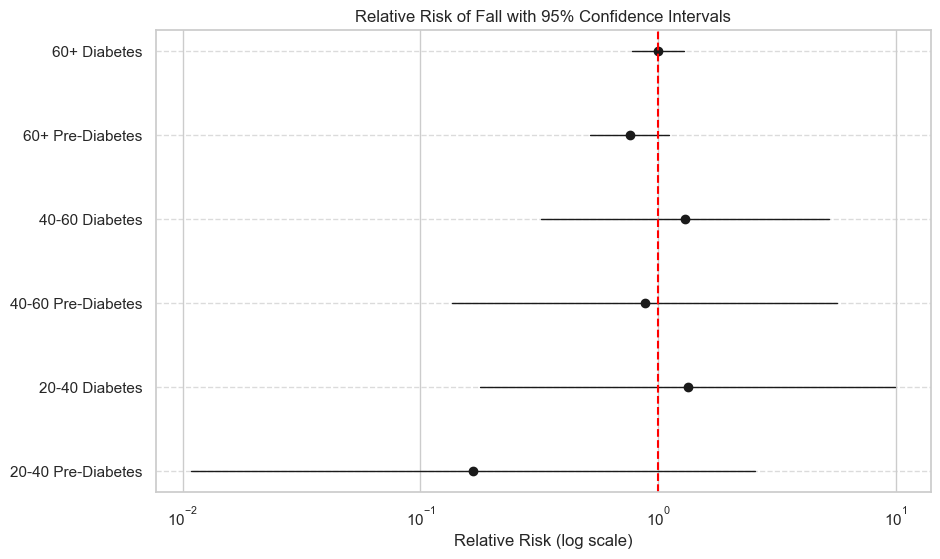

In [ ]:
import matplotlib.pyplot as plt

# Plotting the forest plot
plt.figure(figsize=(10, 6))

# Loop through each condition and age group to plot the relative risk and confidence interval
for i, row in rr_results_statsmodels_df.iterrows():
    plt.plot([row['95% CI Lower'], row['95% CI Upper']], [i, i], 'k-', lw=1)
    plt.plot(row['Relative Risk'], i, 'ko')
    
# Adding labels, title, and grid
plt.yticks(range(len(rr_results_statsmodels_df)), 
           ['20-40 Pre-Diabetes', '20-40 Diabetes', '40-60 Pre-Diabetes', '40-60 Diabetes', '60+ Pre-Diabetes', '60+ Diabetes'])
plt.xscale('log')  # Set x-axis to log scale for better visualization of data spanning several orders of magnitude
plt.xlabel('Relative Risk (log scale)')
plt.title('Relative Risk of Fall with 95% Confidence Intervals')
plt.axvline(x=1, color='red', linestyle='--')  # Line of no effect
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


The forest plot above displays the relative risks and their 95% confidence intervals for each condition (Pre-Diabetes and Diabetes) across different age groups (20-40, 40-60, 60+). The red dashed line represents a relative risk of 1, indicating no difference in risk between the groups being compared.

The "ko" on the plot represents the relative risk point estimate, and the horizontal lines represent the 95% confidence intervals. A confidence interval that crosses the red dashed line suggests that the relative risk is not statistically significantly different from 1, indicating no difference in risk between the groups

In [ ]:
# Create a contingency table for the U69 complication across the different conditions
contingency_table_U69 = pd.crosstab(treatment_1['U69.*'], treatment_1['condition'])

# Perform a Chi-square test to assess the statistical difference between the conditions
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table_U69)

chi2_stat, p_val


(2.5288118519674883, 0.2824070169870924)

In [ ]:
# Step 2: Calculate the relative risks, 95% confidence intervals, and p-values without age stratification

# Create a contingency table without age stratification
contingency_table_U69_no_age_strat = pd.crosstab(treatment_1['U69.*'], treatment_1['condition'])

# Calculate relative risk and confidence intervals with statsmodels
rr_df_U69_no_age_strat = calculate_relative_risk_with_statsmodels(contingency_table_U69_no_age_strat.values)

# Calculate p-values and add to the dataframe
rr_df_U69_no_age_strat['p-value'] = rr_df_U69_no_age_strat.apply(
    lambda row: calculate_p_value(contingency_table_U69_no_age_strat.iloc[:, :2].values + 0.5) if row['Condition'] == 'Pre-Diabetes' 
    else calculate_p_value(contingency_table_U69_no_age_strat.iloc[:, [0, 2]].values + 0.5), axis=1
)

rr_df_U69_no_age_strat


,Condition,Relative Risk,95% CI Lower,95% CI Upper,p-value
0,Pre-Diabetes,0.673661,0.313177,1.449082,0.315103
1,Diabetes,0.757336,0.577209,0.993675,0.582021


The Chi-square statistic is approximately  2.53 and the p-value is approximately 0.282

Given that all p-values are greater than 0.05, we conclude that there is no statistically significant difference in the relative risks of the "U69" complication between the pre-diabetes and diabetes groups compared to the no diabetes group

In [ ]:
# Create a contingency table for the U69 complication with the new age stratification
contingency_table_U69_age_strat = treatment_1.groupby(['age_group', 'condition'])['U69.*'].agg(['sum', 'count']).unstack(fill_value=0)
contingency_table_U69_age_strat.columns = contingency_table_U69_age_strat.columns.droplevel()

# Display the new contingency table
contingency_table_U69_age_strat


condition,Diabetes,No Diabetes,Pre-Diabetes,Diabetes,No Diabetes,Pre-Diabetes
age_group,,,,,,
20-40,0.0,1.0,0.0,6,323,3
40-60,0.0,4.0,0.0,49,452,27
60+,5.0,10.0,0.0,255,717,108


In [ ]:
# Function to calculate p-value using chi2_contingency from scipy.stats
def calculate_p_value(contingency_table):
    _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

# Function to calculate relative risk and 95% confidence interval using statsmodels library
def calculate_relative_risk_with_statsmodels(contingency_table):
    results = []
    
    # Calculate relative risk and 95% CI for pre-diabetes vs no_diabetes
    table_pre_diabetes = Table2x2(contingency_table[:, :2])
    rr_pre_diabetes = table_pre_diabetes.riskratio
    ci_pre_diabetes = table_pre_diabetes.riskratio_confint()
    
    results.append({
        'Condition': 'Pre-Diabetes',
        'Relative Risk': rr_pre_diabetes,
        '95% CI Lower': ci_pre_diabetes[0],
        '95% CI Upper': ci_pre_diabetes[1],
    })
    
    # Calculate relative risk and 95% CI for diabetes vs no_diabetes
    table_diabetes = Table2x2(contingency_table[:, [0, 2]])
    rr_diabetes = table_diabetes.riskratio
    ci_diabetes = table_diabetes.riskratio_confint()
    
    results.append({
        'Condition': 'Diabetes',
        'Relative Risk': rr_diabetes,
        '95% CI Lower': ci_diabetes[0],
        '95% CI Upper': ci_diabetes[1],
    })
    
    return pd.DataFrame(results)

# Recreate contingency tables for each age group and calculate relative risks with statsmodels library
rr_results_statsmodels_U69 = []

for age_group in age_groups:
    # Create a contingency table for the age group
    contingency_table = pd.crosstab(treatment_1[treatment_1['age_group'] == age_group]['U69.*'], 
                                    treatment_1[treatment_1['age_group'] == age_group]['condition'])
    
    # Ensure the contingency table has rows for both outcomes (0 and 1) for each condition
    for condition in ['no_diabetes', 'pre_diabetes', 'diabetes']:
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 0).any()):
            contingency_table.loc[0, condition] = 0
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 1).any()):
            contingency_table.loc[1, condition] = 0
    
    # Sort the index to have a proper contingency table structure
    contingency_table.sort_index(inplace=True)
    
    # Calculate relative risk and confidence intervals with statsmodels
    rr_df = calculate_relative_risk_with_statsmodels(contingency_table.values)
    rr_df['Age Group'] = age_group
    
    # Calculate p-values and add to the dataframe
    rr_df['p-value'] = rr_df.apply(lambda row: calculate_p_value(contingency_table.iloc[:, :2].values + 0.5) if row['Condition'] == 'Pre-Diabetes' 
                                   else calculate_p_value(contingency_table.iloc[:, [0, 2]].values + 0.5), axis=1)
    
    rr_results_statsmodels_U69.append(rr_df)

# Combine the results from all age groups into a single dataframe
rr_results_statsmodels_U69_df = pd.concat(rr_results_statsmodels_U69, axis=0).reset_index(drop=True)
rr_results_statsmodels_U69_df


,Condition,Relative Risk,95% CI Lower,95% CI Upper,Age Group,p-value
0,Pre-Diabetes,0.054878,0.004988,0.603731,20-40,1.000000
1,Diabetes,1.333333,0.177997,9.987693,20-40,1.000000
2,Pre-Diabetes,0.887324,0.064164,12.270846,40-60,1.000000
3,Diabetes,1.289474,0.180356,9.219220,40-60,1.000000
4,Pre-Diabetes,0.783699,0.380110,1.615807,60+,0.649046
5,Diabetes,0.768156,0.584691,1.009191,60+,0.476355


In [ ]:
# Recreate contingency tables for each age group and calculate relative risks with statsmodels library
rr_results_statsmodels = []

for age_group in age_groups:
    # Create a contingency table for the age group
    contingency_table = pd.crosstab(treatment_1[treatment_1['age_group'] == age_group]['U69_High'], 
                                    treatment_1[treatment_1['age_group'] == age_group]['condition'])
    
    # Ensure the contingency table has rows for both outcomes (0 and 1) for each condition
    for condition in ['no_diabetes', 'pre_diabetes', 'diabetes']:
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 0).any()):
            contingency_table.loc[0, condition] = 0
        if not ((contingency_table.columns == condition).any() and (contingency_table.index == 1).any()):
            contingency_table.loc[1, condition] = 0
    
    # Sort the index to have a proper contingency table structure
    contingency_table.sort_index(inplace=True)
    
    # Calculate relative risk and confidence intervals with statsmodels
    rr_df = calculate_relative_risk_with_statsmodels(contingency_table.values)
    rr_df['Age Group'] = age_group
    rr_results_statsmodels.append(rr_df)

# Combine the results from all age groups into a single dataframe
rr_results_statsmodels_df_U69 = pd.concat(rr_results_statsmodels, axis=0).reset_index(drop=True)
rr_results_statsmodels_df_U69

KeyError: 'U69_High'

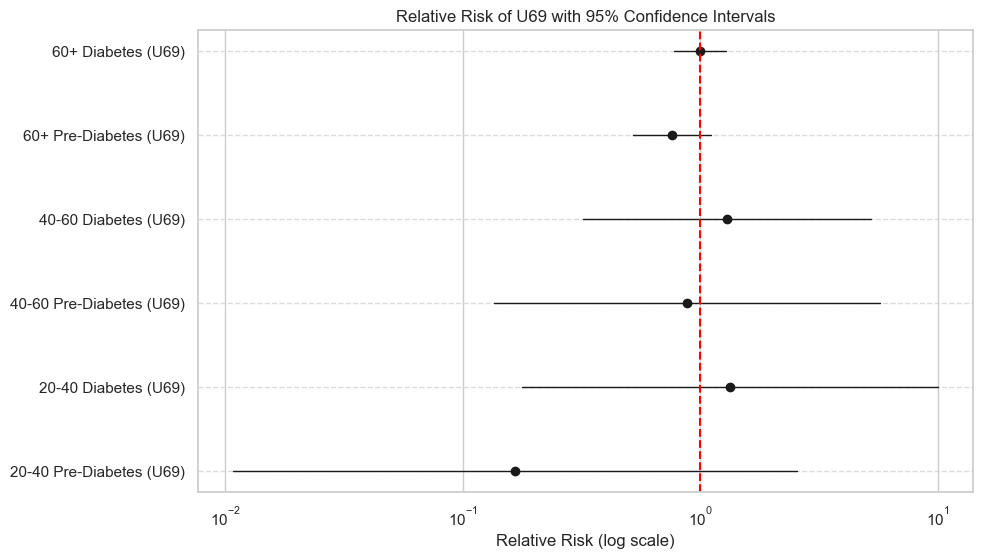

In [ ]:
# Creating the forest plot for U69
plt.figure(figsize=(10, 6))

# Loop through each condition and age group to plot the relative risk and confidence interval
for i, row in rr_results_statsmodels_df.iterrows():
    plt.plot([row['95% CI Lower'], row['95% CI Upper']], [i, i], 'k-', lw=1)
    plt.plot(row['Relative Risk'], i, 'ko')
    
# Adding labels, title, and grid
plt.yticks(range(len(rr_results_statsmodels_df)), 
           ['20-40 Pre-Diabetes (U69)', '20-40 Diabetes (U69)', '40-60 Pre-Diabetes (U69)', '40-60 Diabetes (U69)', '60+ Pre-Diabetes (U69)', '60+ Diabetes (U69)'])
plt.xscale('log')  # Set x-axis to log scale for better visualization of data spanning several orders of magnitude
plt.xlabel('Relative Risk (log scale)')
plt.title('Relative Risk of U69 with 95% Confidence Intervals')
plt.axvline(x=1, color='red', linestyle='--')  # Line of no effect
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


   Chi-square value   p-value
0          2.528812  0.282407


C:\Users\Mehak Rafiq\AppData\Local\Temp\ipykernel_20036\1939408287.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='condition', y=variable, data=df, ci=None)


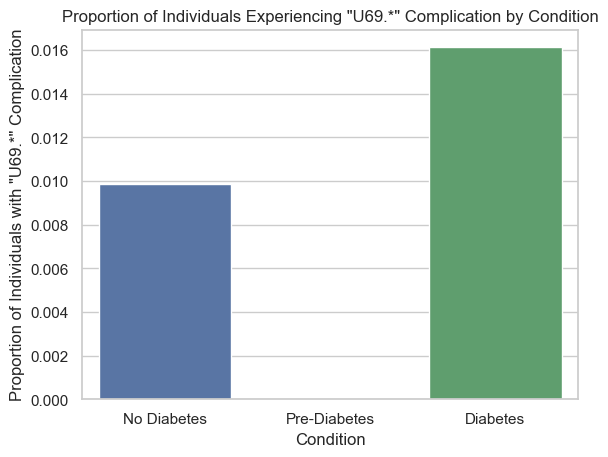

In [ ]:
# Define function to perform chi-square tests and visualize the results
def perform_chi_square_tests(df, variable):
    # Create a contingency table for the overall population and each condition
    contingency_table = pd.crosstab(df[variable], df['condition'])
    
    # Perform chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    # Compile the chi-square results into a dataframe
    chi2_results = pd.DataFrame({
        'Chi-square value': [chi2],
        'p-value': [p_value],
    })

    # Print chi-square results
    print(chi2_results)

    # Create a bar plot to visualize the proportion of individuals with the complication in each group
    sns.barplot(x='condition', y=variable, data=df, ci=None)

    # Add labels and title to the plot
    plt.ylabel(f'Proportion of Individuals with "{variable}" Complication')
    plt.xlabel('Condition')
    plt.title(f'Proportion of Individuals Experiencing "{variable}" Complication by Condition')

    # Display the plot
    plt.show()

# Use the function with the variable of interest
perform_chi_square_tests(df=treatment_1, variable='U69.*')